- Ronald Matthew Montehermoso
- A13732474
- COGS118C - Assignment 2

# This notebook has [45 + 5 bonus] points in total 
##### The number of points for each question is denoted by []. Make sure you've answered all the questions and that the point total add up.

# Lab 2 - Fourier Analysis & Coding Your Own DFT
In this lab, we will learn about Fourier analysis the hands-on way: through building your own Discrete Fourier transform (DFT). You will employ complex sinusoids and dot products from Lab 0, and apply your DFT to a real signal to measure neural oscillations via the power spectrum. There is a bonus section at the end to explain aliasing in the frequency domain.

Key concepts:

- Cosine and Sine waves
- Dot product, revisited
- Complex exponential, magnitude and phase
- Wave number and frequency
- Power spectrum
- Aliasing

# Discrete Fourier Transform
It's useful to keep the formula for DFT in mind, as we step through each component for building it in code.

![](img/DFT_formula.png)
from [Wikipedia][WP_DFT].

[WP_DFT]:https://en.wikipedia.org/wiki/Discrete_Fourier_transform

To unpack that scary-looking equation, notice first that the summation expression is performing a dot product between two discrete-time signals: our signal $x(n)$ and the complex exponential in polar form. 

The second line simply rewrites the complex exponential using Euler's formula, and because of the linearity of the dot product, we can treat the sine and cosine separately.

k is the wave number, which is analogous to frequency.

** At its core, the DFT turns an array of numbers, our signal in time, into another array of numbers, its "frequency domain representation".**

In [1]:
# make the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io

# Load the LFP signal
Today, we'll be working with LFP recorded in the rat hippocampus. This dataset comes from an openly accessible neuroscience database. For more information on this particular dataset, see [here](https://crcns.org/data-sets/hc/hc-2/about-hc-2).

As was with last assignment, we will load the .mat file into python, and unpack the dictionary (I've done all this for you). In this file, LFP values are actually stored as integers (representing ADC levels), so we'll just label the y-axis as voltage without specifying a particular unit (like mV). 

dict_keys(['__header__', '__version__', '__globals__', 'lfp', 'fs', 'spike_indices', 'spike_fs'])
Sampling rate = 1250Hz


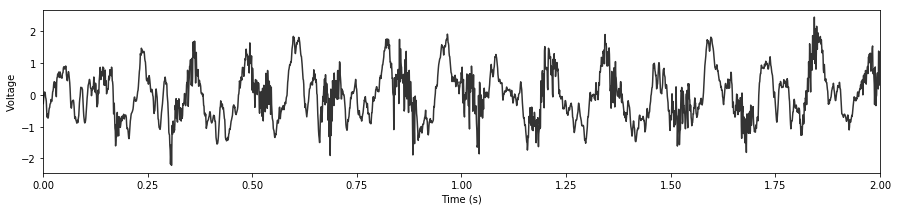

In [2]:
data = io.loadmat('./data/LFP.mat', squeeze_me=True)
print(data.keys())

# unpack the variables
fs = data['fs'] # sampling rate 
print('Sampling rate = %iHz'%fs)

lfp = data['lfp'][0,:]/1000 # this file contains two channels, we'll only work with the first one
lfp_short = lfp[:int(2*fs)] # make a variable that has only the first two seconds of the LFP
t_short = np.arange(0, len(lfp_short)/fs, 1/fs) # create the corresponding time vector

plt.figure(figsize=(15,3))
plt.plot(t_short,lfp_short, 'k', alpha=0.8)
plt.xlim([0,2])
plt.xlabel('Time (s)');plt.ylabel('Voltage');

# Neural Oscillations
You will notice that the LFP signal has a very prominent rhythmic component, with peaks near, for example, 0.25, 0.37, and 0.5 seconds. Therefore, it has a **periodicity of about 0.125 seconds**, or a **frequency of 8Hz**. This is a very famous brain oscillation, called the theta oscillation. 

Fourier, or frequency domain analysis, is particularly useful for characterizing this type of rhythmic brain signal. The method has a long history from electrical and systems engineering, both for describing signals and processes that generate signals (linear time invariant systems). But first, we'll construct the primary ingredient of the Fourier Transform: **sine waves**.

# [10] Q1: Sine and Cosine Waves
Before we start analyzing the neural data, we have to go over the concept of sine waves. As we alluded to above, the (Discrete) Fourier Transform is a series of dot products, between sines/cosines of different frequencies and our signal. This might be a little confusing, if you are mainly familiar with computing the cosine of an angle, which gives you a single number back. For example, the cosine of 90 degrees (or $\pi/2$) is 0. 

Here, we want a sine *wave*, i.e., to compute cosine and sine over time to produce a vector, and you can think of that as computing the cosine of different "angles" at the same time points as your LFP signal. But what are these angles?

It's helpful to picture a clock in your head. A clock's seconds hand rotates around the circle, which has 360 degrees, or $2\pi$ radians. Every second, it moves clockwise by a little bit. 1/60th of $2\pi$, to be exact. Therefore, at every time point, you can compute the cosine of the **angle between the seconds hand and 12 o'clock** (due North). 

**(Note that, mathematically, the reference for 0 degree is actually 3 o'clock, or due East. But we'll use 12 o'clock for this question because it's a little more intuitive.)**

---
[1] Let `t=0` be the start of the minute (pointing at 12 o'clock). What is the angle (in radians) between the seconds hand and the reference (12 o'clock) at `t=15` seconds? Save that in the variable `angle_t15`. Hint: `np.pi` has the value for $\pi$.

[1] What is the cosine and sine of that angle? Answer this here without coding.

ANSWER: sine = 1, cosine = 0

[1] Complete the code to compute and print the quantities above and make sure this is what you expected.

[1] What is the angle at `t=30` seconds? What is the cosine and sine of that angle?

ANSWER: The angle is a 180 degree angle, or pi in radians. sine = 0, cosine = -1

[1] After how many seconds will the angle be $2\pi$? In other words, in how many seconds will the seconds hand have completed a full revolution around the clock? 

ANSWER: The clock should complete a full revolution in 60 seconds.

[1] What is the frequency of rotation of the seconds hand on a clock (in cycles per second, Hz)? Store that in the variable `clock_freq`.

[4] The above questions gave you two points where time is mapped to angle. In code below, compute the corresponding angle (**in radians**) for all time points in the time vector `t_clock`, and store it in the variable `angle_clock`. Note, you should use the variables `t_clock`, `clock_freq`, and the constant $\pi$. Then, using this angle array, compute the cosine and sine of the entire vector and store them in `cos_clock` and `sin_clock`. Finally, plot both the cosine and sine values over time. Remember to label your lines and axes. Hint: both cosine and sine should go through just a single cycle.

3.141592653589793
1.0
6.123233995736766e-17
[1.         1.         0.99999999 ... 0.99999997 0.99999999 1.        ]
[ 0.00000000e+00  8.37758040e-05  1.67551607e-04 ... -2.51327410e-04
 -1.67551607e-04 -8.37758040e-05]


Text(0, 0.5, 'Amplitude')

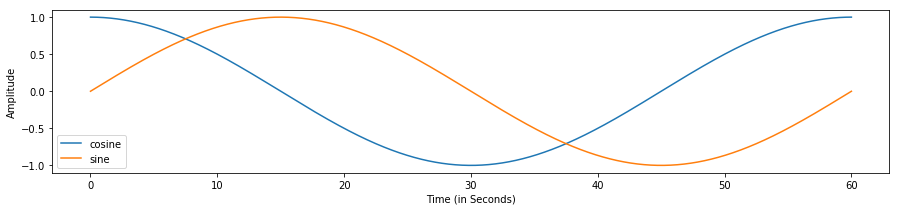

In [9]:
print(np.pi) # print the value for pi

# compute the cosine and sine at t=15 seconds
angle_t15 = (15 / 60) * (2 * np.pi)

# print the cosine and sine of that angle
print(np.sin(angle_t15))
print(np.cos(angle_t15))

clock_freq = 1/60

t_clock= np.arange(0,60,1/fs)

angle_clock = t_clock * (clock_freq * (2 * np.pi))

cos_clock = np.cos(angle_clock)
sin_clock = np.sin(angle_clock)

print(cos_clock)
print(sin_clock)

plt.figure(figsize=(15,3))

plt.plot(t_clock, cos_clock, label = 'cosine')
plt.plot(t_clock, sin_clock, label = 'sine')
plt.legend()
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amplitude')

# [5] Q2: Cosine and Sine Dot Product
You should be familiar with how to construct a cosine and sine wave of a particular frequency at this point. To start analyzing our brain data, we'll use a cosine/sine of a different frequency: 8Hz. 

[1] Make an 8Hz cosine and sine wave (store in variables `cos` and `sin`) using the time vector `t_short` and the frequency variable `freq`. This should be analogous to what you did above.

[1] Plot, in the same graph, the 2 seconds of LFP signal (already done), as well as the cosine and sine you have just generated. Remember to label the traces and axes. 

[1] How many cycles should an 8Hz oscillation go through in 2 seconds? Count the peaks in your plot to make sure the answer is what you expect.

ANSWER:

[2] Compute the dot product between the 2 second chunk of LFP and the cosine vector, and store in the variable `a_coef`; repeat for the LFP and the sine vector, store in variable `b_coef`. 

355.11525874773554 -663.1592906945903


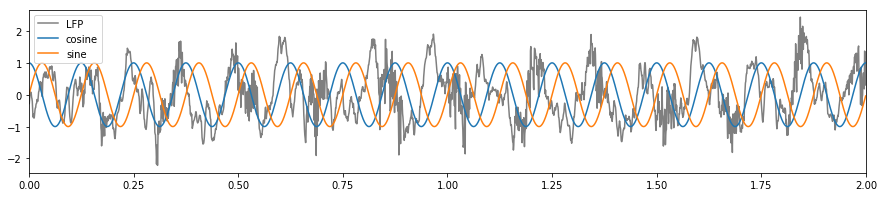

In [16]:
freq = 8 # Hz
angle = t_short * (8 * (2 * np.pi))
cos = np.cos(angle)
sin = np.sin(angle)
plt.figure(figsize=(15,3))
plt.plot(t_short, lfp_short, 'k', label='LFP', alpha=0.5)
plt.plot(t_short, cos, label = 'cosine')
plt.plot(t_short, sin, label = 'sine')
plt.xlim([0,2]); plt.legend()

a_coef = np.dot(lfp_short, cos)
b_coef = np.dot(lfp_short, sin)
print(a_coef, b_coef)

# [5] Q2 - continued
We'll be generating sine waves and performing the dot product very often from this point on, so we better make them into functions. Complete the functions below. Note that you essentially already wrote all the code in the cell above, we just want to wrap them inside functions for convenience.

[1] For the function `make_cos_sin`: given a time vector `t`, and a frequency of interest `freq`, return the corresponding cosine and sine waves.

[2] For the function `dot_cos_sin`: given a signal, the associated time vector, and the frequency of interest, first make cosine and sine waves by calling the function `make_cos_sin`, then compute and return the dot product between `signal` and the cosine and sine wave.

[1] Call your function `dot_cos_sin` to repeat the above analysis (for 8Hz waves). Confirm that you get the same answer as above. Print the value.

[1] Perform the same computation, but for 30Hz cosine/sine waves.

In [19]:
def make_cos_sin(t, freq):    
    
    angle = t * (freq * (2 * np.pi))
    cos = np.cos(angle)
    sin = np.sin(angle)
    
    return cos, sin

def dot_cos_sin(signal, t, freq):
    
    cos, sin = make_cos_sin(t, freq)
    a_coef = np.dot(signal, cos)
    b_coef = np.dot(signal, sin)
    
    return a_coef, b_coef

# compute the dot products for 8Hz cosine and sine waves
freq = 8
print(dot_cos_sin(lfp_short, t_short, freq))

# compute the dot products for 30Hz cosine and sine waves
freq=30
# _FILL_IN_YOUR_CODE_HERE
print(dot_cos_sin(lfp_short, t_short, freq))

(355.11525874773554, -663.1592906945903)
(19.802550750977826, 4.756835689910389)


# [3 + 2 Bonus] Q3: Complex Exponential, Power (Amplitude), and Phase
Why did we just do that? One way to conceptualize the DFT is that it's a "sinusoidal sieve": by passing a signal through the DFT, we split up the signal into different frequencies, and measure the **independent** contribution of each of those component frequencies. This is what a prism does, separating white light into lights of different frequencies. What we did in Q2 was to construct a small part of the sieve, creating the "hole" at 8Hz and 30Hz. Passing the signal through (via dot product) "filters" out everything except the component of the signal at 8Hz. It's like wearing red goggles: it blocks/absorbs all other colors except red. 

---
We performed two dot products with the cosine and sine waves, separately computing `a_coef` and `b_coef`. But if you refer to the first line of the DFT equation, you see that it's actually performing just a single dot product: the signal dotted with (projected onto) the complex exponential. Using Euler's formula, we can separate the complex exponential into a real (cosine) and an imaginary (sine) component. The computed coefficients, `a_coef` and `b_coef`, are the real and imaginary component of that dot product result, which form a 2D (complex) vector.

![](./img/complex_exp.png)
Adapted from [Better Explained](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/).

What is this complex number, `(a_coef + i*b*coef)`? This complex number gives us the signals power (or amplitude) and phase delay at a particular frequency, such as 8Hz. Power is how much the 8Hz component contributes to (or is in) the signal, while phase is the angular shift we have to apply to the cosine (real) component to find maximum alignment with the signal, or the "starting point". To get power and phase, we have to convert that complex number from rectangular to polar coordinate, which we did in Lab 0. 

**Note**: power is squared amplitude (or squared magnitude) by convention. The FT returns amplitude and phase, so that's what we will be doing.

---
[BONUS: 2] Construct the complex exponential using `np.exp`, and perform the dot product directly with the signal `lfp_short`, confirm that you get the same complex number as `(a_coef + i*b*coef)`, which I've printed for you.

[2] Complete the function `compute_amp_phase` for computing the amplitude (magnitude) and phase (angle) from the coefficients. You may use the numerical formula for magnitude and angle in A0, or use `np.abs()` and `np.angle()` on the complex number itself.

[1] Using the above function, find the magnitude and phase of the 8Hz component of the signal. Store them in the variables `amp` and `phase`.

In [ ]:
# BONUS: computing the dot product from the complex exponential
complex_exp = # _FILL_IN_YOUR_CODE_HERE
# print the dot product
print() # _FILL_IN_YOUR_CODE_HERE

# computing the dot product separately
freq = 8
a_coef, b_coef = dot_cos_sin(lfp_short, t_short, freq)
print(a_coef-1j*b_coef) # printing the coefficients as a complex number, note the minus in front of sin

def compute_amp_phase(a_coef, b_coef):
    # _FILL_IN_YOUR_CODE_HERE    
    return amp, phase

amp, phase = # _FILL_IN_YOUR_CODE_HERE
print(amp,phase)

---
# Intermission
Well done! You have built from scratch the atomic element of the Fourier Transform in python. To recap, we've gone over the concept of a time-varying sinusoid, created a cosine and sine wave (components of the complex exponential) that have a specific frequency (8Hz), projected our signal onto these "sinusoidal bases" to get the Fourier coefficients, and computed the magnitude and phase of the signal at 8Hz. To construct the full DFT, we just have to perform this sequence of operations:
- create complex exponential/sinusoidal bases at a particular frequency
- perform dot product to get complex coefficients
- compute magnitude and phase

and iterate over all the frequencies of interest. 

### The last questions are: at *how many* frequencies, and *which* frequencies?

---

# [8] Q4: Wave Number & Frequencies of DFT
In the questions above, we've cherrypicked a particular frequency (8Hz), and used that sieve to query for the contribution of the 8Hz component in our signal. To build the full DFT, you have to complete the sieve. A sieve merely separates components of a material, it does not make anything disappear. The same is true for the DFT. The real ingenuity behind the Fourier Transform is that a signal - *any signal* - can be decomposed into contributions from sinusoidal components (or bases), if you pick the right frequencies. In other words, from the signal's Fourier transform, you can reconstruct the original signal with 100% accuracy, using the *inverse* Fourier Transform.

One idea is to simply do this for every single possible frequency, 8Hz, 8.1Hz, 8.01Hz, etc. But we quickly realize that there are an infinite number of frequencies along the real number line, and that's probably an overkill anyway. If our discrete time signal is only 1000-points long, using a million sinusoids to represent that isn't very clever.

The intuitive answer (and the right answer) is that **we need as many frequencies as we have samples in the signal itself**. In the LFP signal above (`lfp_short`), there are 2500 points, so we need 2500 frequencies of sine waves to deconstruct that signal. 

---
The unintuitive part is that the DFT operation doesn't know (or care) about frequency in terms of real time, i.e., Hz. You can compute the DFT of any sequence of numbers, and it will return the coefficients from the dot product. **What it cares about is the "wave number", `k`, of the sinusoids, which always goes from 0 to N-1 (see eq.1).** The sampling rate of your signal, then, determines how fast in real clock time those wave numbers correspond to in units of Hz. So, in reality, the 8Hz above is actually computed from a wave number.

![](./img/DFT_formula.png)

To think about the wave numbers (somewhat) intuitively, think of a clock again, but a weird one. You have N of these clocks (N is the length of your sigal). All of these clocks have the same faces, which is the full circle equally divided into N equal partitions. Instead of always moving forward 1/60th of a circle, each clock moves forward by a different amount at each "time step". The 0th clock (k=0) moves 0/N steps per time step, so it always stays still (this is an especially weird one). The 1st clock (k=1) moves clockwise by 1/N steps on each time step. Hence, in N time steps, it will have completed just a single revolution around the clock. 

** In general, the kth clock will complete k revolutions around the clock after N steps. Altogether, these clocks are all the possible ones that complete an integer number of revolutions around the clock after N steps, from 0 times to N-1 times.**

To compute their physical frequency in Hz, we need to know how much each time step is, in terms of real time. This is determined by our signal we are trying to analyze, and is simply the variable `dt` that we've been working with, or `1/fs`.

---
[1] For `N=2000` and `fs=1000`, how long (in seconds) does the first sine wave (`k=1`) take to complete a single cycle/ revolution around the circle? (The weird clock might be helpful here: how many steps does it take to complete one cycle, and how much time passes with each step?) Provide your reasoning in words or equation.

ANSWER:

[1] What is its frequency, in Hz (cycles per second)? Hint: this is just the inverse of the above answer

ANSWER: 

[1] What is the frequency of the 16th wave (`k=16`) in Hz? Follow the same process as the last two questions.

ANSWER:

[1] What is the frequency of the 16th wave (`k=16`) in Hz, when `N=4000` and `fs=500`?

ANSWER: 

[3] From those examples, provide the general formula for wave frequency in Hz, given its wave number `k`, total number of samples `N`, and sampling frequency `fs`. Hint: it's a simple algebraic expression using only these 3 terms. Complete the function below for computing this in code, and use that to confirm your answer for the last 3 questions. Print the results.

ANSWER:

[1] In Q2, we used the 8Hz sine wave, with `fs=1250` and `N=2500`. What is its corresponding wave number, `k`? (k starts from 0.)

ANSWER:

---
(`np.fft.fftfreq` is numpy's function for computing the frequency vector (in Hz) given `N` and `fs` or `dt`. I'm printing it beside your function calls to help you make sure you have the right answer.)

In [ ]:
def freq_from_k(k, N, fs):
    # k can be a number or an array, the same expression should work

    # _FILL_IN_YOUR_CODE_HERE
    return 

k, N, fs = 
print(freq_from_k(k, N, fs), np.fft.fftfreq(N,1/fs)[k])

k, N, fs = 
print(freq_from_k(k, N, fs), np.fft.fftfreq(N,1/fs)[k])

k, N, fs = 
print(freq_from_k(k, N, fs), np.fft.fftfreq(N,1/fs)[k])

# [+2 Bonus] Negative Frequencies & Aliasing - A Caveat
In the plot below, I plotted the computed wave frequency of all the wave numbers using your function (blue), as well as using numpy's function (orange). From k=0 to 1250, the two lines should overlap (if your function is doing the right thing). After 1250Hz, however, your function should keep returning increasing wave frequencies for increasing wave number, while numpy returns **negative** frequencies.

In short, in the strange clock example, a negative frequency would be when the hand rotates **counterclockwise**. For wave number `k=N-1`, for example, after a single time step, you can picture that as the hand jumping clockwise **almost** all the way around the full circle, to the last tick mark. OR, you can picture it as the hand jumping a single step counterclockwise, to -1/N. Because everything we work with is in discrete time, these two scenarios are indistinguishable, and the boundary at which this phenomenon occurs is at `k=N/2`, which corresponds to `fs/2`. This is known as the **Nyquist frequency**, and it's where sinusoidal rotations start to appear as if they are rotating backwards. See [here](https://www.youtube.com/watch?v=VNftf5qLpiA) for a visual demonstration. This is also what gives rise to **aliasing**, which we will explore in detail in the last section.

[BONUS: 2] Uncomment the code below. Write a modified version of your `freq_from_k` function inside `freq_from_k_nyq` such that it returns negative wave frequencies for frequencies greater than the Nyquist frequency. Call the function and store the result in `your_freqs_nyq`, and plot it in the same plot. It should overlap completely with the numpy result.

In [ ]:
# def freq_from_k_nyq(k, N, fs):
# _FILL_IN_YOUR_CODE_HERE
#     return

N, fs = 2500, 1250
k_s = np.arange(0,N)
your_freqs = freq_from_k(k_s, N, fs)
np_freqs = np.fft.fftfreq(N, 1/fs)
# your_freqs_nyq = # _FILL_IN_YOUR_CODE_HERE

plt.figure(figsize=(5,5))
plt.plot(k_s,your_freqs, label='Your Wave Frequencies')
plt.plot(k_s,np_freqs, label='numpy Wave Frequencies')
# plt.plot() # _FILL_IN_YOUR_CODE_HERE

plt.legend()
plt.xlabel('Wave Number (k)')
plt.ylabel('Wave Frequency (Hz)');

---
# [6] Q5: DFT - Bringing Everything Together

Now, you have all the components for writing your own Discrete Fourier Transform! To recap: 
- you can compute the corresponding cosine and sine wave frequencies given the wave numbers (0 to N-1)
- you have a function that returns the wave frequencies (`freq_from_k`, or just call `np.fft.fftfreq`)
- you have a function that creates the cosine and sine waves, given a frequency, and perform the dot product to get the coefficients

### Your job is now to combine these parts to make the function `my_dft`.

---
[1] Compute the wave frequencies using either your function `freq_from_k`, or `np.fft.fftfreq`, for the given `N` and `fs`. Store that in the variable `freqs`. This should be a vector of all frequencies of interest, in Hz.

[2] Complete the function `my_dft`, which computes the Fourier coefficients for `signal`, given the time vector `t` and frequency vector `freqs`. Hint: you will probably need some kind of loop here, or list comprehension.

[1] Call your function `my_dft` to compute the Fourier Transform of our snippet of LFP data, `lfp_short`, and store it in the variable `F_lfp`.

[2] Complete the 2 lines of plotting code that plots the real and imaginary components of your Fourier Transform as the y-values, while the x-values is the frequency axis (`freqs`). They should overlap completely with the numpy result. Depending on how you implemented `my_dft`, you may return the coefficients as a 2-dimensional array, or a 1-dimensional array of complex numbers, so index your array accordingly. Also, depending which function you called in part 2 to compute your frequency vector, this plot might look different, for the reason explained in the last section. Label your axes.

In [ ]:
fs = 1250
N = len(lfp_short)

freqs = # _FILL_IN_YOUR_CODE_HERE

def my_dft(signal, t, freqs):
    # _FILL_IN_YOUR_CODE_HERE
    return 

F_lfp = # _FILL_IN_YOUR_CODE_HERE
F_lfp_np = np.fft.fft(lfp_short) # calling np.fft to make sure you have the right answers

# plotting code
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
# _FILL_IN_YOUR_CODE_HERE
plt.plot(_FILL_IN_YOUR_CODE_HERE, 'o-', alpha=0.5, label='My DFT')
plt.plot(freqs, F_lfp_np.real, '.-', alpha=0.5, label='numpy FFT')
plt.legend()

plt.subplot(2,1,2)
plt.plot(_FILL_IN_YOUR_CODE_HERE, 'o-', alpha=0.5) # you might need a negative in front of the imag component
plt.plot(freqs, F_lfp_np.imag, '.-', alpha=0.5)

# print the first 10 coefficients to make sure they're the same
# the signs will be flipped for the imaginary component
print(F_lfp[:5,:])
print(F_lfp_np[:5])


# [3 + 1 Bonus] Q6: Power Spectrum
The above two plots are the real and imaginary coefficients spectra. While looking at them is interesting, we are often interested in another spectrum, the **power spectrum** of a signal, which is the squared magnitude of the complex vector (defined by coefficients `a_coef` and `b_coef`) at every frequency. This representation tells us which components are the strongest (has the highest power) in our data.

[1] Compute the array of power values from your Fourier coefficients `F_lfp`, and store it in the variable `my_power`.

[1] Plot the power spectrum (the x-axis is, again, frequency `freqs`), and zoom into the first 100Hz. Remember to label your axes. It should overlap completely with the numpy-computed power.

[1] By looking at the power spectrum of the LFP data, what frequency contributes the most (has the most power)? Is this consistent with time series plot in Q2? Justify your response.

ANSWER:

[BONUS: 1] Confirm that your Fourier transform follows [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem) by computing and printing the values from both sides of this equation:
![](./img/parseval.png)

In [ ]:
my_power = # _FILL_IN_YOUR_CODE_HERE
np_power = np.abs(F_lfp_np)**2

plt.figure(figsize=(6,6))
plt.plot(# _FILL_IN_YOUR_CODE_HERE)
plt.plot(freqs, np_power, '.', alpha=0.5, label='numpy Power')
plt.legend()
plt.xlim([0,100])

# Parseval's theorem
# _FILL_IN_YOUR_CODE_HERE

# [5] Q6 - continued
[3] Repeat the above analysis, but for the full LFP signal (`lfp`, I've re-defined for you). Plot the power spectrum (and remember to label your axes).

[2] Comment on similarities and differences between this plot and the above.

ANSWER:

In [ ]:
fs = data['fs'] # sampling rate
lfp = data['lfp'][0,:]/1000

# _FILL_IN_YOUR_CODE_HERE

# Congratulations!
You have just performed your first frequency (Fourier) analysis on real neural recordings. Computing and looking at the power spectrum is one of the most common ways of characterizing neural signals, especially for identifying strong rhythmic components in the data (neural oscillations). Almost every lab on campus that works with EEG, ECoG, or LFPs will at some point compute a power spectrum to look for rhythmic signals, including Profs. Lara Rangel, Doug Nitz, Brad Voytek, and many more. Neural oscillations is a huge field of neuroscience research, and there's plenty of work to be done here!

# End Survery
Please take a few minutes to fill out the following as it will help us to improve the following assignments & lectures.

# Content:
What was one thing you learned from this lab & associated lectures?

ANSWER: 

---
What was one thing that you still found confusing after the lab, and need clarification?

ANSWER:

# Style:
What was one thing you enjoyed about the formatting of this assignment (e.g., clarity, structure, guidance, etc.)?

ANSWER:

---
What was one thing that you thought could use improvements on?

ANSWER:


# Thank you!

---
# Alising & Nyquist Sampling Theorem in Frequency Domain
Some bonus material: we now have the machinary to examine what exactly happens in the frequency domain when a signal is undersampled, thus causing aliasing. Let's start with a finely sampled sinusoid, with an oscillation frequency of 14Hz, sampled with a sampling rate of 1000Hz. 

We can then create a downsampled version of our signal by taking every 50th sample, which gives us an effective sampling rate of 1000/50 = 20Hz. By the Nyquist sampling theorem, we know that for a signal of frequency B, we have to sample at least 2B Hz. In other words, if the sampling rate is fs, the highest frequency signal we can resolve is fs/2, which is called the Nyquist frequency. 

Now, our downsampled signal is sampled at 20Hz, which means we can resolve a signal of at most 10Hz. Remember the weird clocks? Well, if a 14Hz signal sampled at 20Hz is like rotating around the circle clockwise 14 times per second, it will produce the same sequence of clock positions as if it's rotating around the circle counterclockwise 6 times per second, or -6Hz. The math is $14-20 = -6$

Explore different values for the variables `cos_freq` and `ds_factor` and re-run the code to see which frequencies will not be aliased, i.e., the blue and orange traces in the power spectrum plot overlap.

In [ ]:
fs = 1000
t = np.arange(0,5,1/fs)
cos_freq = 14
signal = np.cos(2*np.pi*cos_freq*t) # this is our sinusoidal signal

# downsampling
ds_factor = 50
fs_ds = fs/ds_factor
print(fs_ds)
t_ds = t[::ds_factor]
signal_ds = signal[::ds_factor]

plt.figure(figsize=(15,3))
plt.plot(t, signal)
plt.plot(t_ds, signal_ds, 'o-')
plt.xlabel('Time (s)');plt.ylabel('Voltage');
plt.xlim([0,1])

# compute power spectrum of original signal
f_signal = np.fft.fftfreq(len(signal), 1/fs)
power_signal = np.abs(np.fft.fft(signal))
print(f_signal[np.where(power_signal==max(power_signal))])

# compute power spectrum of downsampled signal
f_signal_ds = np.fft.fftfreq(len(signal_ds), 1/(fs_ds))
power_signal_ds = np.abs(np.fft.fft(signal_ds))*(len(signal)/len(signal_ds))
print(f_signal_ds[np.where(power_signal_ds==max(power_signal_ds))])

plt.figure(figsize=(5,5))
plt.plot(f_signal, power_signal, '-o', label='Original Signal')
plt.plot(f_signal_ds, power_signal_ds, '-o', label='Downsampled Signal')
plt.xlabel('Frequency (Hz)');plt.ylabel('Power');
plt.xlim([-40,40]); plt.legend()